## First Models

First models on the department GPU

In [1]:
import logging

def configure_logger():
    root_logger = logging.getLogger()
    root_logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)

## Preprocessing


In [2]:
import os

import numpy as np
import pandas as pd

In [3]:
LENGTH, WIDTH, HEIGHT = (120, 120, 64)

VALID_TRAINING_INDICES = []
VALID_VALIDATION_INDICES = []

def load_training_data() -> np.array:
    """Returns a 4D matrix of the training data.

     The data is in the form (n_samples, l, w, h). The samples
     are sorted by patient ID.
     """
    arrays = []
    training_filenames = sorted(os.listdir(
        '/home/lzhu7/data/numpy_split/training'))
    for i, filename in enumerate(training_filenames):
        arr = np.load('/home/lzhu7/data/numpy_split/training/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            arrays.append(arr)
            VALID_TRAINING_INDICES.append(i)
        else:
            logging.info(
                f'training file {filename} has incorrect shape {arr.shape}')
    return np.stack(arrays)


def load_validation_data() -> np.array:
    """Returns a 4D matrix of the validation data.

     The data is in the form (n_samples, l, w, h). The samples
     are sorted by patient ID.
    """
    arrays = []
    validation_filenames = sorted(os.listdir(
        '/home/lzhu7/data/numpy_split/validation'))
    for i, filename in enumerate(validation_filenames):
        arr = np.load('/home/lzhu7/data/numpy_split/validation/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            arrays.append(arr)
            VALID_VALIDATION_INDICES.append(i)
        else:
            logging.info(
                f'validation file {filename} has incorrect shape {arr.shape}')
    return np.stack(arrays)


def load_labels() -> (np.array, np.array):
    training_df = pd.read_csv('/home/lzhu7/data/training_labels.csv')
    validation_df = pd.read_csv('/home/lzhu7/data/validation_labels.csv')
    training_labels = training_df.sort_values('patient_id')['label'].values
    validation_labels = validation_df.sort_values('patient_id')['label'].values
    return training_labels, validation_labels

In [11]:
configure_logger()
X_train = load_training_data()
logging.info(f'loaded training data with shape {X_train.shape}')
y_train, _ = load_labels()
logging.info(f'loaded training labels with shape {y_train.shape}')
y_train = y_train[VALID_TRAINING_INDICES]
logging.info(f'filtered training labels to shape {y_train.shape}')

2018-06-12 12:06:46,726 - root - INFO - loaded training data with shape (500, 120, 120, 64)
2018-06-12 12:06:46,726 - root - INFO - loaded training data with shape (500, 120, 120, 64)
2018-06-12 12:06:46,742 - root - INFO - loaded training labels with shape (500,)
2018-06-12 12:06:46,742 - root - INFO - loaded training labels with shape (500,)
2018-06-12 12:06:46,744 - root - INFO - filtered training labels to shape (1000,)
2018-06-12 12:06:46,744 - root - INFO - filtered training labels to shape (1000,)


In [12]:
# Uncomment to see validation data
# X_valid = load_validation_data()
# logging.info(f'loaded validation data with shape {X_valid.shape}')
# _, y_valid = load_labels()
# logging.info(f'loaded validation labels with shape {y_valid.shape}')
# y_valid = y_valid[VALID_VALIDATION_INDICES]
# logging.info(f'filtered validation labels to shape {y_valid.shape}')

## Data Exploration

In [13]:
%matplotlib inline

## More preprocessing

In [6]:
def normalize(X: np.array, mean: float, std: float):
    return (X - mean) / std

In [7]:
def squash_height(X: np.array):
    return X.max(axis=3)

In [15]:
X_mean = X_train.mean()
X_std = X_train.std()
X_train = normalize(X_train, X_mean, X_std)
# X_valid = normalize(X_valid, X_mean, X_std)

In [16]:
X_train_squashed = np.expand_dims(squash_height(X_train), axis=3)

# X_valid_squashed = np.expand_dims(squash_height(X_valid), axis=3)

X_train_squashed.shape

(500, 120, 120, 1)

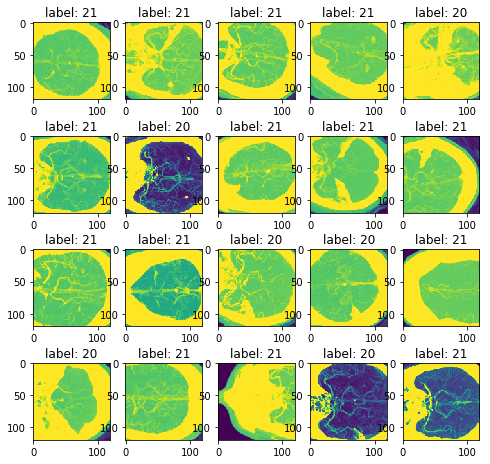

In [38]:
import matplotlib.pyplot as plt

ROWS = 4
COLS = 5
OFFSET = 20
fig = plt.figure(figsize=(8, 8))
for i in range(20):
    ax = fig.add_subplot(ROWS, COLS, i + 1)
    ax.set_title(f'label: {y_train[i]}')
    plt.imshow(squash_height(X_train)[i + OFFSET])

In [ ]:
# X_train_3d = np.expand_dims(X_train, axis=4)
# X_valid_3d = np.expand_dims(X_valid, axis=4)

In [20]:
X_train_squashed_shuffle = np.random.permutation(X_train_squashed)

## Model training

In [21]:
import keras
import tensorflow as tf
from keras import layers, optimizers
from keras.backend.tensorflow_backend import set_session

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
# set_session(tf.Session(config=config))

Using TensorFlow backend.
/gpfs/main/home/lzhu7/elvo-analysis/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
def build_model() -> keras.Model:
    """This initially worked fine.
    """
    model = keras.Sequential()
    model.add(layers.Conv2D(128,
                            (3, 3),
                            activation='relu',
                            input_shape=(LENGTH, WIDTH, HEIGHT)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', use_bias=False, padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', use_bias=False, padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', use_bias=False, padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(512, (3, 3), activation='relu', use_bias=False, padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', use_bias=False, padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(1024, (3, 3), activation='relu', use_bias=False, padding='same'))
    model.add(layers.Conv2D(1024, (3, 3), activation='relu', use_bias=False, padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu', use_bias=False))
    model.add(layers.Dense(1024, activation='relu', use_bias=False))
    model.add(layers.Dense(1, activation='sigmoid', use_bias=False))

    model.compile(optimizer=optimizers.Adam(lr=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [30]:
def build_model_squashed() -> keras.Model:
    """This doesn't work well.
    """
    model = keras.Sequential()
    model.add(layers.Conv2D(32,
                            (3, 3),
                            activation='relu',
                            input_shape=(LENGTH, WIDTH, 1)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizers.Adam(lr=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def build_model_3d() -> keras.Model:
    model = keras.Sequential()
    model.add(layers.Conv3D(64,
                            (3, 3, 3),
                            activation='relu',
                            padding='same',
                            input_shape=(LENGTH, WIDTH, HEIGHT, 1)))
    model.add(layers.MaxPool3D())
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool3D())
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPool3D())
    model.add(layers.Conv3D(256, (3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(256, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPool3D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dense(1000, activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizers.Adam(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [36]:
model = build_model_squashed()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 118, 118, 32)      320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 118, 118, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 59, 59, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 29, 29, 256)       295168    
__________

In [37]:
history = model.fit(X_train_squashed_shuffle, y_train, batch_size=64, epochs=100, validation_split=0.25)
#                     validation_data=(X_valid, y_valid))

Train on 375 samples, validate on 125 samples
Epoch 1/100
375/375 [==============================] - 3s 8ms/step - loss: 0.6851 - acc: 0.5787 - val_loss: 0.6977 - val_acc: 0.5280
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 0.6732 - acc: 0.6000 - val_loss: 0.7014 - val_acc: 0.5280
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.6699 - acc: 0.6000 - val_loss: 0.7026 - val_acc: 0.5280
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 0.6705 - acc: 0.6000 - val_loss: 0.7034 - val_acc: 0.5280
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 0.6705 - acc: 0.6000 - val_loss: 0.6992 - val_acc: 0.5280
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 0.6661 - acc: 0.6000 - val_loss: 0.6974 - val_acc: 0.5280
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 0.6653 - acc: 0.6000 - val_loss: 0.6973 - val_acc: 0.5280
Epoch 8/100
375/375 [==

KeyboardInterrupt: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


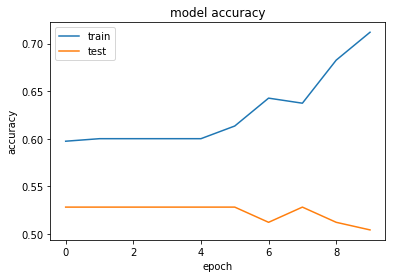

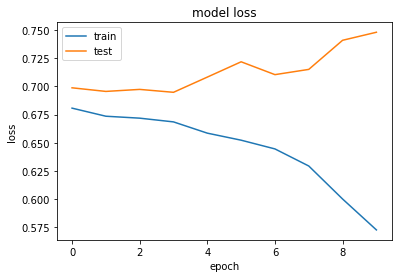

In [29]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.predict(X_train[0:10])

In [ ]:
model.predict(X_valid[0:10])

In [ ]:
# import time
# model.save(f'model-{time.time()}.hdf5')